In [24]:
import numpy as np
import pickle

SIZE = 3
class State:
    def __init__(self, p1, p2):
        self.board = np.zeros((SIZE, SIZE))
        self.p1 = p1
        self.p2 = p2
        self.isEnd = False
        self.boardHash = None

        # init p1 plays first
        self.playerSymbol = -1

    def getHash(self): # get unique hash of current board state
        self.boardHash = str(self.board.reshape(SIZE * SIZE))
        return self.boardHash

    def checkWinner(self): # player 1 win returns 1, player 2 win returns -1, tie returns 0.
        # check row
        for i in range(SIZE):
            if sum(self.board[i, :]) == SIZE:
                self.isEnd = True
                return 1
            if sum(self.board[i, :]) == -SIZE:
                self.isEnd = True
                return -1
            
        # check col
        for i in range(SIZE):
            if sum(self.board[:, i]) == SIZE:
                self.isEnd = True
                return 1
            if sum(self.board[:, i]) == -SIZE:
                self.isEnd = True
                return -1
            
        # check diagonal
        diag_sum1 = sum([self.board[i, i] for i in range(SIZE)])
        diag_sum2 = sum([self.board[i, SIZE - i - 1] for i in range(SIZE)])
        if diag_sum1 == SIZE or diag_sum2 == SIZE:
            self.isEnd = True
            return 1
        if diag_sum1 == -SIZE or diag_sum2 == -SIZE:
            self.isEnd = True
            return -1

        # tie (no available ava_positions)
        if len(self.availablePositions()) == 0:
            self.isEnd = True
            return 0
        
        # not end
        self.isEnd = False
        return None

    def availablePositions(self): # （需要优化一下）return must be tuples where board[i,j]==0
        ava_positions = []
        for i in range(SIZE):
            for j in range(SIZE):
                if self.board[i, j] == 0:
                    ava_positions.append((i, j))
        return ava_positions

    def updateState(self, position): # store record and switch to another player
        self.board[position] = self.playerSymbol
        self.playerSymbol = -(self.playerSymbol)

    # only backpropagate reward when game ends
    def giveReward(self): ### ！！！记得改这里！！！
        result = self.checkWinner()
        if result == 1:
            self.p1.feedReward(1)
            self.p2.feedReward(0)
        elif result == -1:
            self.p1.feedReward(0)
            self.p2.feedReward(1)
        else: 
            self.p1.feedReward(0.1)
            self.p2.feedReward(0.5)

    def reset(self): # board reset to initial state
        self.board = np.zeros((SIZE, SIZE))
        self.boardHash = None
        self.isEnd = False
        self.playerSymbol = 1

    def play(self, rounds): # for training rounds of iterations, each iteration play until end of game
        for i in range(rounds):
            # if i % 1000 == 0:
            #     print("Rounds {}".format(i))
            while not self.isEnd:
                # Player 1
                ava_positions = self.availablePositions()
                p1_action = self.p1.chooseAction(ava_positions, self.board, self.playerSymbol) # take action
                self.updateState(p1_action) # update state
                board_hash = self.getHash()
                self.p1.addState(board_hash)
            
                if self.checkWinner() is not None:
                    self.giveReward()
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break

                else:
                    # Player 2
                    ava_positions = self.availablePositions()
                    p2_action = self.p2.chooseAction(ava_positions, self.board, self.playerSymbol) # take action
                    self.updateState(p2_action) # update state
                    board_hash = self.getHash()
                    self.p2.addState(board_hash)

                    if self.checkWinner() is not None:
                        self.giveReward()
                        self.p1.reset()
                        self.p2.reset()
                        self.reset()
                        break

    def play_game(self): # start to play with human
        while not self.isEnd:
            # Player 1
            ava_positions = self.availablePositions()
            p1_action = self.p1.chooseAction(ava_positions, self.board, self.playerSymbol) # take action
            self.updateState(p1_action) # update state
            # self.showBoard()
            # check board status if it is end
            win = self.checkWinner()
            if win is not None:
                self.reset()
                if win == 1:
                    return 1
                    # print(self.p1.name, "wins!")
                else:
                    return 0
                    # print("tie!")
                # self.reset()
                # break

            else:
                # Player 2
                ava_positions = self.availablePositions()
                p2_action = self.p2.chooseAction(ava_positions) # take action
                self.updateState(p2_action) # update state
                # self.showBoard()
                win = self.checkWinner()
                if win is not None:
                    self.reset()
                    if win == -1:
                        return -1
                        # print(self.p2.name, "wins!")
                    else:
                        return 0
                        # print("tie!")
                    # break

    def showBoard(self): # player 1: x  player 2: o
        for i in range(0, SIZE):
            print('-'+'----'*SIZE)
            out = '| '
            for j in range(0, SIZE):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('-'+'----'*SIZE)


In [25]:
class Player:
    def __init__(self, name, exp_rate = 0.3):
        self.name = name
        self.states = []  # record all ava_positions taken
        self.lr = 0.2
        self.exp_rate = exp_rate
        self.decay_gamma = 0.9
        self.states_value = {}  # state -> value

    def getHash(self, board):
        boardHash = str(board.reshape(SIZE * SIZE))
        return boardHash

    def chooseAction(self, ava_positions, current_board, symbol):
        if np.random.uniform(0, 1) <= self.exp_rate:
            idx = np.random.choice(len(ava_positions)) # take random action
            action = ava_positions[idx]
        else:
            value_max = -999
            for p in ava_positions:
                next_board = current_board.copy()
                next_board[p] = symbol
                next_boardHash = self.getHash(next_board)
                value = 0 if self.states_value.get(next_boardHash) is None else self.states_value.get(next_boardHash)
                if value >= value_max:
                    value_max = value
                    action = p
        # print("{} takes action {}".format(self.name, action))
        # print('state:', self.states_value)
        return action

    # append a hash state
    def addState(self, state):
        self.states.append(state)

    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        for st in reversed(self.states):
            if self.states_value.get(st) is None:
                self.states_value[st] = 0
            self.states_value[st] += self.lr * (self.decay_gamma * reward - self.states_value[st])
            reward = self.states_value[st]

    def reset(self):
        self.states = []

    def savePolicy(self):
        fw = open('policy_' + str(self.name), 'wb')
        pickle.dump(self.states_value, fw)
        fw.close()

    def loadPolicy(self, file):
        fr = open(file, 'rb')
        self.states_value = pickle.load(fr)
        fr.close()

class HumanPlayer:
    def __init__(self, name):
        self.name = name

    def chooseAction(self, ava_positions):
        while True:
            # row = int(input("Input your action row:"))
            # col = int(input("Input your action col:"))
            # action = (row, col)
            # if action in ava_positions:
            #     return action
            idx = np.random.choice(len(ava_positions)) # take random action
            action = ava_positions[idx]
            return action
            

    # append a hash state
    def addState(self, state):
        pass

    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        pass

    def reset(self):
        pass

In [26]:
# class RandomPlayer:
import matplotlib.pyplot as plt
if __name__ == "__main__":
    # training
    Keep_p1_rate = []
    Keep_p2_rate = []
    Keep_tie_rate = []
    X = [i for i in range(100)]
    for i in range(100):
        p1_time = 0
        p2_time = 0
        tie_time = 0
        for times in range(100):
            p1 = Player("p1")
            p2 = Player("p2")
            st = State(p1, p2)
            st.play(i)
            p1.savePolicy()
            p2.savePolicy()
            p1 = Player("computer", exp_rate=0)
            p1.loadPolicy("policy_p1")
            p2 = HumanPlayer("human")
            st = State(p1, p2)
            out = st.play_game()
            if out == 1:
                p1_time += 1
            elif out == -1:
                p2_time += 1
            elif out == 0:
                tie_time += 1
        print(i)
        Keep_p1_rate.append(p1_time/100)
        Keep_p2_rate.append(p2_time/100)
        Keep_tie_rate.append(tie_time/100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


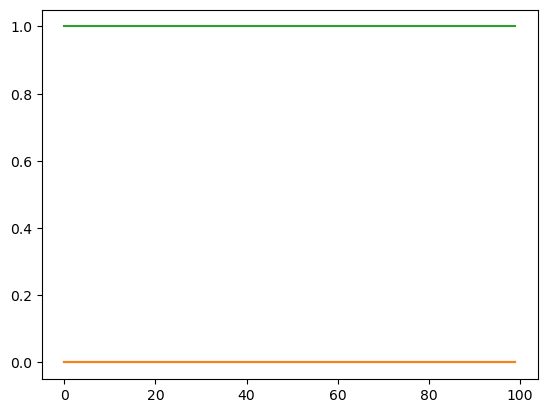

In [27]:
plt.plot(X, Keep_p1_rate)
plt.plot(X, Keep_p2_rate)
plt.plot(X, Keep_tie_rate)
plt.show()